In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

1) Analytic Bayes (credit example) — compute posterior step-by-step

In [3]:
# Analytic Bayes: credit default example
p_default = 0.04                    # P(A)
p_miss_given_default = 0.70         # P(B|A)
p_miss_given_no_default = 0.10      # P(B|A')

# Compute P(B) via law of total probability
p_no_default = 1 - p_default
p_miss = p_miss_given_default * p_default + p_miss_given_no_default * p_no_default

# Posterior: P(A|B)
p_default_given_miss = (p_miss_given_default * p_default) / p_miss

print("P(Default) =", p_default)
print("P(Miss | Default) =", p_miss_given_default)
print("P(Miss | No Default) =", p_miss_given_no_default)
print("P(Miss) =", round(p_miss, 4))
print("P(Default | Miss) =", round(p_default_given_miss, 4))

P(Default) = 0.04
P(Miss | Default) = 0.7
P(Miss | No Default) = 0.1
P(Miss) = 0.124
P(Default | Miss) = 0.2258


2) Monte-Carlo Simulation — verify the analytic result

In [4]:
np.random.seed(0)
N=200000

# simulate true defaults (A)
default = np.random.rand(N) < 0.04   # True with prob 0.04

# simulate Miss EMI (B) conditional on default status
miss = np.empty(N, dtype=bool)
# if default True -> miss with prob 0.7, else with prob 0.1
miss[default] = np.random.rand(default.sum()) < 0.70
miss[~default] = np.random.rand((~default).sum()) < 0.10

# empirical posterior
p_miss_emp = miss.mean()
p_default_and_miss_emp = (default & miss).mean()
p_posterior_emp = p_default_and_miss_emp / p_miss_emp

print("Empirical P(Miss) =", round(p_miss_emp, 4))
print("Empirical P(Default & Miss) =", round(p_default_and_miss_emp, 4))
print("Empirical P(Default | Miss) =", round(p_posterior_emp, 4))

Empirical P(Miss) = 0.1254
Empirical P(Default & Miss) = 0.0274
Empirical P(Default | Miss) = 0.2188


3) Diagnostic test example (sensitivity, specificity, base rate fallacy)

Scenario (medical or fraud):

Disease prevalence (prior) = 1%

Test sensitivity = 95% (P(Test+ | Disease))

Test specificity = 90% (P(Test- | No disease))

Compute P(Disease | Test+).

In [10]:
p_disease=0.01
sensitivity=0.95
specificity=0.90
p_no_disease=1-p_disease

p_test_pos=p_disease*sensitivity + (1-specificity)*p_no_disease

p_disease_given_test=sensitivity*p_disease/p_test_pos

print("P(Test+):", round(p_test_pos, 4))
print("P(Disease | Test+):", round(p_disease_given_test, 4))

P(Test+): 0.1085
P(Disease | Test+): 0.0876


4) Naïve Bayes — tiny synthetic classification demo (explainable)

Purpose: show how Bayes is used in a classifier (assumes conditional independence across features).

In [11]:
# Simple Naive Bayes demo using conditional probabilities (manual)
# Two features: 'clicked_promo' (yes/no) and 'high_income' (yes/no)
# Class: 'buys_product' (1) or 'not_buy' (0)

# Priors:
p_buy = 0.2
p_not_buy = 1 - p_buy

# Likelihoods (estimated from historical data)
# P(clicked_promo | buy), P(clicked_promo | not_buy)
p_click_given_buy = 0.6
p_click_given_notbuy = 0.1

# P(high_income | buy), P(high_income | notbuy)
p_high_given_buy = 0.5
p_high_given_notbuy = 0.2

# Example new user: clicked_promo = True, high_income = True
# Naive Bayes (assume independence between features given class)
likelihood_buy = p_click_given_buy * p_high_given_buy
likelihood_notbuy = p_click_given_notbuy * p_high_given_notbuy

unnorm_p_buy_given_features = likelihood_buy * p_buy
unnorm_p_notbuy_given_features = likelihood_notbuy * p_not_buy

# normalize to get posterior probabilities
p_features = unnorm_p_buy_given_features + unnorm_p_notbuy_given_features
p_buy_given_features = unnorm_p_buy_given_features / p_features

print("P(buy | clicked, high) ≈", round(p_buy_given_features, 4))


P(buy | clicked, high) ≈ 0.7895


MICRO-PROJECT 1 — CREDIT-RISK SCORING WITH BAYES

🎯 GOAL:
ESTIMATE THE PROBABILITY THAT A BORROWER WILL DEFAULT GIVEN NEW EVIDENCE SUCH AS A MISSED EMI OR A LATE-PAYMENT FLAG.


In [14]:
np.random.seed(42)
n=10000
default=np.random.rand(n)<0.05
missed=np.where(default,
               np.random.rand(n)<0.65,      # 65 % of defaulters miss
               np.random.rand(n) < 0.12)   # 12 % of non-defaulters miss   
                
df = pd.DataFrame({'default': default, 'missed': missed})
df.head()

,default,missed
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [15]:
p_default=df['default'].mean()
p_missed_given_default=df.query('default==True')['missed'].mean()
p_missed_given_no_default=df.query('default==False')['missed'].mean()
p_missed=df['missed'].mean()

posterior=(p_missed_given_default*p_default)/p_missed
print("P(Default | Missed EMI) ≈", round(posterior, 3))

P(Default | Missed EMI) ≈ 0.22


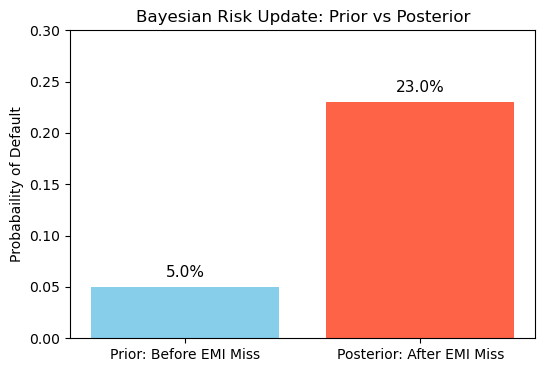

In [20]:
prior=0.05
posterior=0.23

plt.figure(figsize=(6,4))
plt.bar(['Prior: Before EMI Miss', 'Posterior: After EMI Miss'],
         [prior,posterior],
         color=['skyblue','tomato'])
plt.ylim(0,0.3)
plt.ylabel('Probabaility of Default')
plt.title('Bayesian Risk Update: Prior vs Posterior')

for i, val in enumerate([prior, posterior]):
    plt.text(i, val + 0.01, f"{val*100:.1f}%", ha='center', fontsize=11)

plt.show()

Before observing evidence, the estimated default risk was 5% (prior).
After a missed EMI, using Bayes’ theorem, the risk updates to ≈ 23% (posterior).
This visualization demonstrates how new evidence can drastically shift belief — a cornerstone of Bayesian reasoning in credit analytics.

Micro-Project 2 — Fraud Detection Bayesian Update

In [22]:
p_fraud = 0.005
p_alert_given_fraud = 0.9
p_alert_given_notfraud = 0.02
p_alert = p_alert_given_fraud*p_fraud + p_alert_given_notfraud*(1-p_fraud)
p_fraud_given_alert = (p_alert_given_fraud*p_fraud)/p_alert
print("Posterior Fraud Probability ≈", round(p_fraud_given_alert, 3))


Posterior Fraud Probability ≈ 0.184
